<a href="https://colab.research.google.com/github/probml/JSL/blob/main/jsl/demos/ekf_mlp_anim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade git+https://github.com/google/flax.git
!pip install --upgrade tensorflow-probability
!pip install git+https://github.com/blackjax-devs/blackjax.git
!pip install git+https://github.com/deepmind/distrax.git


  Cloning https://github.com/google/flax.git to /tmp/pip-req-build-cc_exfuj
  Running command git clone -q https://github.com/google/flax.git /tmp/pip-req-build-cc_exfuj
     |████████████████████████████████| 136 kB 8.0 MB/s 
     |████████████████████████████████| 72 kB 863 kB/s 
  Created wheel for flax: filename=flax-0.4.1-py3-none-any.whl size=185991 sha256=0e5e09ee2d7b69dc3908aa59be490dc6589bbed4134d7a085e217c5a1ebf2a58
  Stored in directory: /tmp/pip-ephem-wheel-cache-moa6qi0z/wheels/3e/9e/df/f792f5b2c0d0ccf00f3c1286bc060dab7cb2a4af5134d1c5b4
Successfully built flax
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.8.0 requires tf-estimator-n

In [2]:
!pip install git+https://github.com/probml/jsl

  Cloning https://github.com/probml/jsl to /tmp/pip-req-build-783786km
  Running command git clone -q https://github.com/probml/jsl /tmp/pip-req-build-783786km
  Created wheel for jsl: filename=jsl-0.0.0-py3-none-any.whl size=77852 sha256=230ccb9c1fa340890bc1ba3cff6de1b7e7b8b56ab7f5799304862a0b69e85926
  Stored in directory: /tmp/pip-ephem-wheel-cache-z6o1bzx9/wheels/a5/37/42/df04e6049cdb2f348d9fc610c7e3a165b28475340c684858c1
Successfully built jsl


In [3]:

import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jsl.demos import ekf_vs_ukf_mlp as demo
import matplotlib.animation as animation
from functools import partial
from jax.random import PRNGKey, split, normal, multivariate_normal

from jsl.nlds.base import NLDS
from jsl.nlds.extended_kalman_filter import filter


In [4]:
import os

plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

path = os.environ.get("FIGDIR")
path = "." if path is None else path
filepath = os.path.join(path, "samples_hist_ekf.mp4")
print(filepath)

def f(x): return x - 10 * jnp.cos(x) * jnp.sin(x) + x ** 3

fx = f

def fz(W): return W



./samples_hist_ekf.mp4


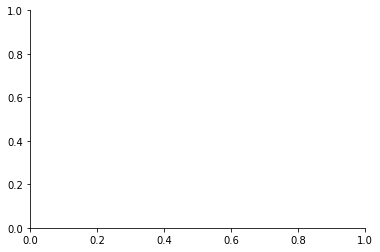

In [5]:
# *** MLP configuration ***
n_hidden = 6
n_in, n_out = 1, 1
n_params = (n_in + 1) * n_hidden + (n_hidden + 1) * n_out
fwd_mlp = partial(demo.mlp, n_hidden=n_hidden)
# vectorised for multiple observations
fwd_mlp_obs = jax.vmap(fwd_mlp, in_axes=[None, 0])
# vectorised for multiple weights
fwd_mlp_weights = jax.vmap(fwd_mlp, in_axes=[1, None])
# vectorised for multiple observations and weights
fwd_mlp_obs_weights = jax.vmap(fwd_mlp_obs, in_axes=[0, None])

# *** Generating training and test data ***
n_obs = 200
key = PRNGKey(314)
key_sample_obs, key_weights = split(key, 2)
xmin, xmax = -3, 3
sigma_y = 3.0
x, y = demo.sample_observations(key_sample_obs, fx, n_obs, xmin, xmax, x_noise=0, y_noise=sigma_y)
xtest = jnp.linspace(x.min(), x.max(), n_obs)

# *** MLP Training with EKF ***
W0 = normal(key_weights, (n_params,)) * 1  # initial random guess
Q = jnp.eye(n_params) * 1e-4;  # parameters do not change
R = jnp.eye(1) * sigma_y ** 2;  # observation noise is fixed
Vinit = jnp.eye(n_params) * 100  # vague prior

ekf = NLDS(fz, fwd_mlp, Q, R)
_, ekf_hist = filter(ekf, W0, y[:, None], x[:, None], Vinit, return_params=["mean", "cov"])
ekf_mu_hist, ekf_Sigma_hist = ekf_hist["mean"], ekf_hist["cov"]

xtest = jnp.linspace(x.min(), x.max(), 200)
nframes = n_obs
fig, ax = plt.subplots()

def func(i, clear=True):
    if clear: plt.cla()
    W, SW = ekf_mu_hist[i], ekf_Sigma_hist[i]
    W_samples = multivariate_normal(key, W, SW, (100,))
    sample_yhat = fwd_mlp_obs_weights(W_samples, xtest[:, None])
    for sample in sample_yhat:
        ax.plot(xtest, sample, c="tab:gray", alpha=0.07)
    ax.plot(xtest, sample_yhat.mean(axis=0))
    ax.scatter(x[:i], y[:i], s=14, c="none", edgecolor="black", label="observations")
    ax.scatter(x[i], y[i], s=30, c="tab:red")
    ax.set_title(f"EKF+MLP ({i + 1:03}/{n_obs})")
    ax.set_xlim(x.min(), x.max())
    ax.set_ylim(y.min(), y.max())

    return ax




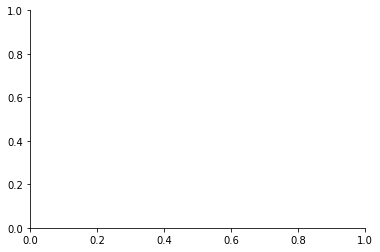

In [7]:

ani = animation.FuncAnimation(fig, func, frames=10) #n_obs)
ani.save(filepath, dpi=200, bitrate=-1, fps=10)